In [2]:
from google.colab import files
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import html5lib
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

#Read in all NHL transactions and filter for trades only
df=pd.read_csv("Hockey_trades_2.csv")
trade_df = df[df['4'].str.contains("trade")]

In [3]:
#Current NHL teams
teams = {"Ducks":{},
"Coyotes":{},
"Bruins":{},
"Sabres":{},
"Flames":{},
"Hurricanes":{},
"Blackhawks":{},
"Avalanche":{},
"BlueJackets":{},
"Stars":{},
"RedWings":{},
"Oilers":{},
"Panthers":{},
"Kings":{},
"Wild":{},
"Canadiens":{},
"Predators":{},
"Devils":{},
"Islanders":{},
"Rangers":{},
"Senators":{},
"Flyers":{},
"Penguins":{},
"Sharks":{},
"Blues":{},
"Lightning":{},
"MapleLeafs":{},
"Canucks":{},
"GoldenKnights":{},
"Capitals":{},
"Jets":{},
                }

In [6]:
trade_df = trade_df.drop(["Unnamed: 0"],axis=1)
trade_df["4"]=trade_df["4"].apply(lambda x: x.replace(' ',''))
trade_df[['Year','Month', 'Day']] = df['0'].str.split('-',expand=True)
trade_df = trade_df.drop(columns="0")


new_df=pd.read_csv("Hockey_trades_1.csv")

new_df = new_df.drop(["index", "Unnamed: 0"],axis=1)
new_df["Players Sent"]=new_df["3"].apply(lambda x: x.count('\u2022'))
new_df["Players Received"]=new_df["2"].apply(lambda x: x.count('\u2022'))
trade_df = new_df[new_df['4'].str.contains("trade")]

trade_df[['Year','Month', 'Day']] = df['0'].str.split('-',expand=True)
trade_df = trade_df.drop(columns="0")
trade_df["4"]=trade_df["4"].apply(lambda x: x.replace(' ',''))

In [36]:
trade_df["4"]=trade_df["4"].apply(lambda x: x.replace('tradewith',''))

In [38]:
trade_df.to_csv("Hockey_trades_final")

In [39]:
files.download('Hockey_trades_final')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
trade_df.tail()

,1,2,3,4,Players Sent,Players Received,Year,Month,Day
81695,Jets,• Jordie Benn,• 2021 sixth round pick (?-?),Canucks,1,1,2021,04,12
81696,Blackhawks,• 2021 fourth round pick (?-?),• Madison Bowey• 2021 fifth round pick (?-?),Canucks,2,1,2021,04,12
81697,Canucks,• Madison Bowey• 2021 fifth round pick (?-?),• 2021 fourth round pick (?-?),Blackhawks,1,2,2021,04,12
81698,Capitals,• Anthony Mantha,• Jakub Vrana• Richard Panik• 2021 first roun...,RedWings,4,1,2021,04,12
81699,Red Wings,• Jakub Vrana• Richard Panik• 2021 first roun...,• Anthony Mantha,Capitals,1,4,2021,04,12


In [41]:
#TODO
#Fix space formating in column 4 xxxx
#Fix data for teams that have moved or changed names
#Split the date columns xxxx
#Variable for players sent/received xxxx

In [48]:
#Build nested dictionary of teams and their trade partners

for index, row in trade_df.iterrows():
    a = row["1"]
    for team in teams.keys():
      if team in row["4"]:
        b=team
        
        if a not in teams.keys():
          continue

        if b not in teams[a].keys():
          teams[a][b] = 1
        else:
          teams[a][b] += 1

#For some reason the csv indicated that a team had traded with itself. Remove these
for team in teams:
  if team in teams[team].keys():
    teams[team].pop(team, None)



In [49]:
teams

{'Avalanche': {},
 'Blackhawks': {},
 'BlueJackets': {},
 'Blues': {},
 'Bruins': {},
 'Canadiens': {},
 'Canucks': {},
 'Capitals': {},
 'Coyotes': {},
 'Devils': {},
 'Ducks': {},
 'Flames': {},
 'Flyers': {},
 'GoldenKnights': {},
 'Hurricanes': {},
 'Islanders': {},
 'Jets': {},
 'Kings': {},
 'Lightning': {},
 'MapleLeafs': {},
 'Oilers': {},
 'Panthers': {},
 'Penguins': {},
 'Predators': {},
 'Rangers': {},
 'RedWings': {},
 'Sabres': {},
 'Senators': {},
 'Sharks': {},
 'Stars': {},
 'Wild': {}}

In [43]:
#Construct the graph
#Edge weights correspond to number of transactions
G = nx.Graph()

for team in teams:
  G.add_node(team)

for team_A in teams:
  for team_B in teams[team_A]:
    G.add_edge(team_A, team_B, weight=teams[team_A][team_B])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


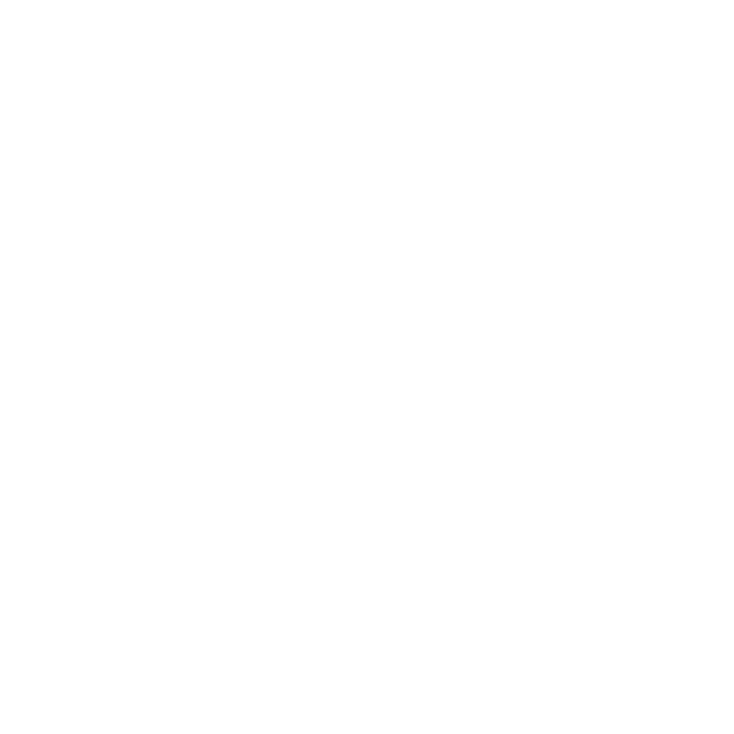

In [45]:
plt.figure(figsize=(10,10))

d = dict(G.degree)
weights = nx.get_edge_attributes(G,'weight').values()


#nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G))
nx.draw(G, nodelist=d.keys(), width=[weight/8 for weight in weights], node_size=[np.log(v) * 500 for v in d.values()], with_labels=True, pos=nx.spring_layout(G),font_color='k',font_size=8)
plt.show()

In [46]:
nx.average_shortest_path_length(G)

NetworkXError: ignored

In [ ]:
page_rank_dict = nx.pagerank(G)

In [ ]:
cups_df=pd.read_csv("stanley_cup_data.csv")

In [ ]:
cups_df.tail()

,Apps,Team,Wins,Losses,Win %,Season(s)
26,1,GoldenKnights,0,1,0.0,2018
27,0,Coyotes,0,0,0.0,0
28,0,BlueJackets,0,0,0.0,0
29,0,Wild,0,0,0.0,0
30,0,Jets,0,0,0.0,0


In [ ]:
for index, row in cups_df.iterrows():
  team = row['Team']
  teams[team]['cup_appearances'] = row['Apps']
  teams[team]['cup_wins'] = row['Wins']
  teams[team]['cup_losses'] = row['Losses']
  teams[team]['cup_win_pct'] = row['Win %']



In [ ]:
page_rank_list=[value for value in page_rank_dict.values()]
cup_app_list = []
for key in page_rank_dict:
  cup_app_list.append(teams[key]["cup_appearances"])

In [ ]:
cup_win_pct_list = []
for key in page_rank_dict:
  cup_win_pct_list.append(teams[key]["cup_win_pct"])

In [ ]:
len(page_rank_list)

31

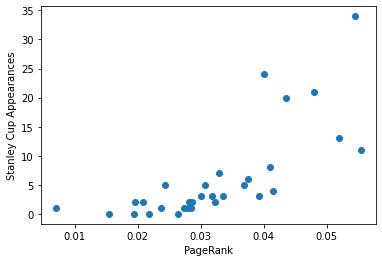

In [ ]:
plt.xlabel("PageRank")
plt.ylabel("Stanley Cup Appearances")
plt.scatter(x=page_rank_list, y=cup_app_list)

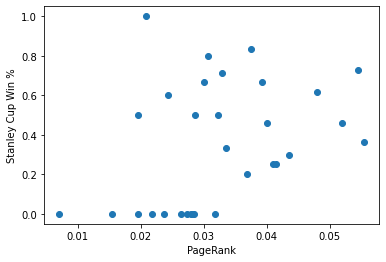

In [ ]:
plt.xlabel("PageRank")
plt.ylabel("Stanley Cup Win %")
plt.scatter(x=page_rank_list, y=cup_win_pct_list)